## 2D Mucus Layer Simulation. Three Distance Scenarios

Does spatial proximity between *Bifido* and *Eubacterium* affect total butyrate output

**Scenarios:**
| Scenario | Bifido x | Eubacterium x |
|----------|----------|---------------|
| Close | 14 | 16 |
| Intermediate | 10 | 20 |
| Far | 3 | 27 |

**Grid:** 30 × 15 (300 µm wide × 150 µm deep), 10 µm per cell  

In [1]:
%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
import copy
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
## Load COBRA Models

base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'

base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

print(f"Bifido: {len(base1.reactions)} rxns, {len(base1.metabolites)} mets, {len(base1.exchanges)} exchanges")
print(f"Eubacterium: {len(base2.reactions)} rxns, {len(base2.metabolites)} mets, {len(base2.exchanges)} exchanges")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Bifido: 1032 rxns, 932 mets, 163 exchanges
Eubacterium: 1051 rxns, 980 mets, 120 exchanges


In [3]:
# Build Exchange Metabolite Union & Add Missing Exchanges

met_to_ex1, met_to_ex2 = {}, {}
for rxn in base1.exchanges:
    if rxn.metabolites:
        met_to_ex1[list(rxn.metabolites.keys())[0].id] = rxn.id
for rxn in base2.exchanges:
    if rxn.metabolites:
        met_to_ex2[list(rxn.metabolites.keys())[0].id] = rxn.id

all_ext_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())
print(f"Total unique external metabolites: {len(all_ext_mets)}")

def add_missing_closed_exchanges(model, met_to_ex_self, all_ext_mets, label):
    met_ids = {m.id for m in model.metabolites}
    rxn_ids = {r.id for r in model.reactions}
    added = 0
    for met_id in all_ext_mets:
        if met_id in met_to_ex_self:
            continue
        if met_id in met_ids:
            met = model.metabolites.get_by_id(met_id)
        else:
            met = cb.Metabolite(met_id, compartment='e')
            model.add_metabolites([met])
            met_ids.add(met_id)
        rxn_id = f'EX_added_{met_id}'
        if rxn_id in rxn_ids:
            continue
        rxn = cb.Reaction(rxn_id)
        rxn.name = f'Dummy exchange for {met_id} (closed)'
        rxn.lower_bound = 0.0
        rxn.upper_bound = 0.0
        rxn.add_metabolites({met: -1.0})
        model.add_reactions([rxn])
        rxn_ids.add(rxn_id)
        added += 1
    #print(f'[{label}] Added {added} closed dummy exchanges')

add_missing_closed_exchanges(base1, met_to_ex1, all_ext_mets, 'Bifido')
add_missing_closed_exchanges(base2, met_to_ex2, all_ext_mets, 'Eubacterium')

Total unique external metabolites: 188


In [4]:
# Set exchange bounds for COMETS
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0


In [5]:
# GRID 

GRID_X = 30
GRID_Y = 15
MUCUS_THICKNESS_UM = 150

SPACE_WIDTH = MUCUS_THICKNESS_UM / GRID_Y / 1e4   # cm per cell = 0.001 cm = 10 µm
BOX_VOL_CM3 = SPACE_WIDTH ** 3
BOX_VOL_ML  = BOX_VOL_CM3
BOX_VOL_L   = BOX_VOL_ML * 1e-3

def mM_to_mmol(conc_mM):
    return conc_mM * BOX_VOL_L

def mmol_to_mM(amount_mmol):
    return amount_mmol / BOX_VOL_L

# Aqueous diffusion coefficients (cm²/s)
D_glucose_aq   = 6.7e-6
D_lactate_aq   = 1.1e-5
D_acetate_aq   = 1.2e-5
D_butyrate_aq  = 0.9e-5
D_generic_aq   = 8.0e-6

MUCUS_FACTOR_GLUCOSE  = 0.003
MUCUS_FACTOR_SECRETED = 0.003
MUCUS_FACTOR_DEFAULT  = 0.003

D_GLUCOSE  = D_glucose_aq  * MUCUS_FACTOR_GLUCOSE
D_LACTATE  = D_lactate_aq  * MUCUS_FACTOR_SECRETED
D_ACETATE  = D_acetate_aq  * MUCUS_FACTOR_SECRETED
D_BUTYRATE = D_butyrate_aq * MUCUS_FACTOR_SECRETED
D_DEFAULT  = D_generic_aq  * MUCUS_FACTOR_DEFAULT

TIME_STEP = 0.01
NUM_DIFF_PER_STEP = 10

In [6]:
# metabolites

GLC_CONC_mM = 10.0
GLC_TOP = mM_to_mmol(GLC_CONC_mM)

WATER_AMOUNT = 1e-4
MAJOR_ION = mM_to_mmol(5.0)
AA_AMOUNT = mM_to_mmol(2.0)
TRACE_AMOUNT = mM_to_mmol(0.1)
VIT_AMOUNT = mM_to_mmol(0.1)

# Metabolite categories
water_proton_ids = {'h2o[e]'}
major_ion_ids = {'pi[e]', 'so4[e]', 'k[e]', 'cl[e]', 'mg2[e]', 'ca2[e]'}
trace_metal_ids = {'fe2[e]', 'fe3[e]', 'zn2[e]', 'cu2[e]', 'mn2[e]', 'cobalt2[e]', 'cd2[e]'}
vitamin_ids = {'ribflv[e]', 'pnto_R[e]', 'nac[e]', 'hxan[e]'}
aa_ids = {'ala_L[e]', 'asn_L[e]', 'his_L[e]', 'leu_L[e]', 'lys_L[e]', 'met_L[e]', 'glycys[e]', 'glyglu[e]'}
glucose_id = 'glc_D[e]'

met_categories = {}
for met_id in all_ext_mets:
    if met_id == glucose_id:
        met_categories[met_id] = ('glucose', GLC_TOP)
    elif met_id in water_proton_ids:
        met_categories[met_id] = ('water_proton', WATER_AMOUNT)
    elif met_id in major_ion_ids:
        met_categories[met_id] = ('major_ion', MAJOR_ION)
    elif met_id in trace_metal_ids:
        met_categories[met_id] = ('trace_metal', TRACE_AMOUNT)
    elif met_id in vitamin_ids:
        met_categories[met_id] = ('vitamin', VIT_AMOUNT)
    elif met_id in aa_ids:
        met_categories[met_id] = ('amino_acid', AA_AMOUNT)

In [7]:
# Biomass motion parameter

D0_biomass = 1e-10
Dn_biomass = 1e-8
n_exp      = 1.0
N_hill     = 2.0
K_half     = 1e-12

# Three Distance Scenarios

In [8]:
# Scenarios

INIT_BIOMASS = 5e-10   # grams 
y_init = 2             
MAX_CYCLES = 600

scenarios = {
    'Close (20 µm)': {'x_bif': 14, 'x_eub': 16},
    'Intermediate (100 µm)': {'x_bif': 10, 'x_eub': 20},
    'Far (240 µm)': {'x_bif': 3, 'x_eub': 27},
}

for name, pos in scenarios.items():
    sep = abs(pos['x_eub'] - pos['x_bif']) * SPACE_WIDTH * 1e4

In [9]:
def run_scenario(base1, base2, x_bif, x_eub, scenario_name):

    print(f"Running: {scenario_name}")
    print(f"  Bifido at x={x_bif}, Eubacterium at x={x_eub}, both at y={y_init}")

    bif = c.model(base1)
    eub = c.model(base2)

    bif.open_exchanges()
    eub.open_exchanges()

    # Clean non-EX exchanges (COMETS fix)
    for m in [bif, eub]:
        ex_mask = m.reactions['EXCH'].isin([True, 'True'])
        exchanges_df = m.reactions[ex_mask]
        for name in exchanges_df['REACTION_NAMES']:
            name = str(name)
            if not name.startswith('EX_'):
                m.reactions.loc[m.reactions['REACTION_NAMES'] == name, 'EXCH'] = False
                m.reactions.loc[m.reactions['REACTION_NAMES'] == name, 'EXCH_IND'] = 0

    bif.initial_pop = [[x_bif, y_init, INIT_BIOMASS]]
    eub.initial_pop = [[x_eub, y_init, INIT_BIOMASS]]

    # Biomass motion
    for m in [bif, eub]:
        m.add_nonlinear_diffusion_parameters(D0_biomass, Dn_biomass, n_exp, N_hill, K_half)

    # Layout
    layout = c.layout([bif, eub])
    layout.grid = [GRID_X, GRID_Y]


    for met in all_ext_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    # Set nutrients (static except glucose)
    for met_id, (category, amount) in met_categories.items():
        if category == 'glucose':
            continue
        if amount > 0:
            layout.set_specific_metabolite(met_id, amount)
            layout.set_specific_static(met_id, amount)

    # Glucose: top row static supply
    for x in range(GRID_X):
        layout.set_specific_metabolite_at_location(glucose_id, (x, 0), GLC_TOP)
        layout.set_specific_static_at_location(glucose_id, (x, 0), GLC_TOP)

    for x in range(GRID_X):
        layout.set_specific_metabolite_at_location(glucose_id, (x, GRID_Y - 1), 0.0)
        layout.set_specific_static_at_location(glucose_id, (x, GRID_Y - 1), 0.0)

    # Metabolite specific diffusion
    layout.set_specific_metabolite_diffusion(glucose_id, D_GLUCOSE)
    secreted_diffusion = {'lac_L[e]': D_LACTATE, 'ac[e]': D_ACETATE, 'but[e]': D_BUTYRATE}
    for met, d_val in secreted_diffusion.items():
        if met in all_ext_mets:
            layout.set_specific_metabolite_diffusion(met, d_val)

    # Parameters
    params = c.params()
    params.set_param('maxCycles', MAX_CYCLES)
    params.set_param('timeStep', TIME_STEP)
    params.set_param('spaceWidth', SPACE_WIDTH)
    params.set_param('exchangestyle', 'Monod Style')
    params.set_param('defaultVmax', 20.0)
    params.set_param('defaultKm', 5e-4)
    params.set_param('defaultHill', 1)
    params.set_param('defaultDiffConst', D_DEFAULT)
    params.set_param('numDiffPerStep', NUM_DIFF_PER_STEP)
    params.set_param('biomassMotionStyle', 'ConvNonlin Diffusion 2D')
    params.set_param('growthDiffRate', 0.0)
    params.set_param('maxSpaceBiomass', 1e-9)
    params.set_param('minSpaceBiomass', 1e-14)
    params.set_param('allowCellOverlap', True)
    params.set_param('deathRate', 0.0)

    LOG_RATE = 5
    params.set_param('writeBiomassLog', True)
    params.set_param('BiomassLogRate', LOG_RATE)
    params.set_param('writeMediaLog', True)
    params.set_param('MediaLogRate', LOG_RATE)
    params.set_param('writeFluxLog', True)
    params.set_param('FluxLogRate', LOG_RATE)
    params.set_param('writeTotalBiomassLog', True)
    params.set_param('totalBiomassLogRate', LOG_RATE)

    # Run
    sim = c.comets(layout, params)
    sim.run()

    return sim

In [10]:
# run simulation

results = {}
for scenario_name, pos in scenarios.items():
    sim = run_scenario(base1, base2, pos['x_bif'], pos['x_eub'], scenario_name)
    results[scenario_name] = sim
    

Running: Close (20 µm)
  Bifido at x=14, Eubacterium at x=16, both at y=2

Running COMETS simulation ...

Debug Here ...
Done!
Running: Intermediate (100 µm)
  Bifido at x=10, Eubacterium at x=20, both at y=2

Running COMETS simulation ...

Debug Here ...
Done!
Running: Far (240 µm)
  Bifido at x=3, Eubacterium at x=27, both at y=2

Running COMETS simulation ...

Debug Here ...
Done!


In [12]:
sim = results['Close (20 µm)']
sim.total_biomass

,cycle,Bifido,Eubacterium
0,0,5.000000e-10,5.000000e-10
1,5,5.000951e-10,5.004613e-10
2,10,5.006502e-10,5.023662e-10
3,15,5.013521e-10,5.050182e-10
4,20,5.020460e-10,5.079450e-10
...,...,...,...
116,580,7.123855e-10,1.907937e-09
117,585,7.150413e-10,1.926820e-09
118,590,7.176947e-10,1.945794e-09
119,595,7.203464e-10,1.964890e-09


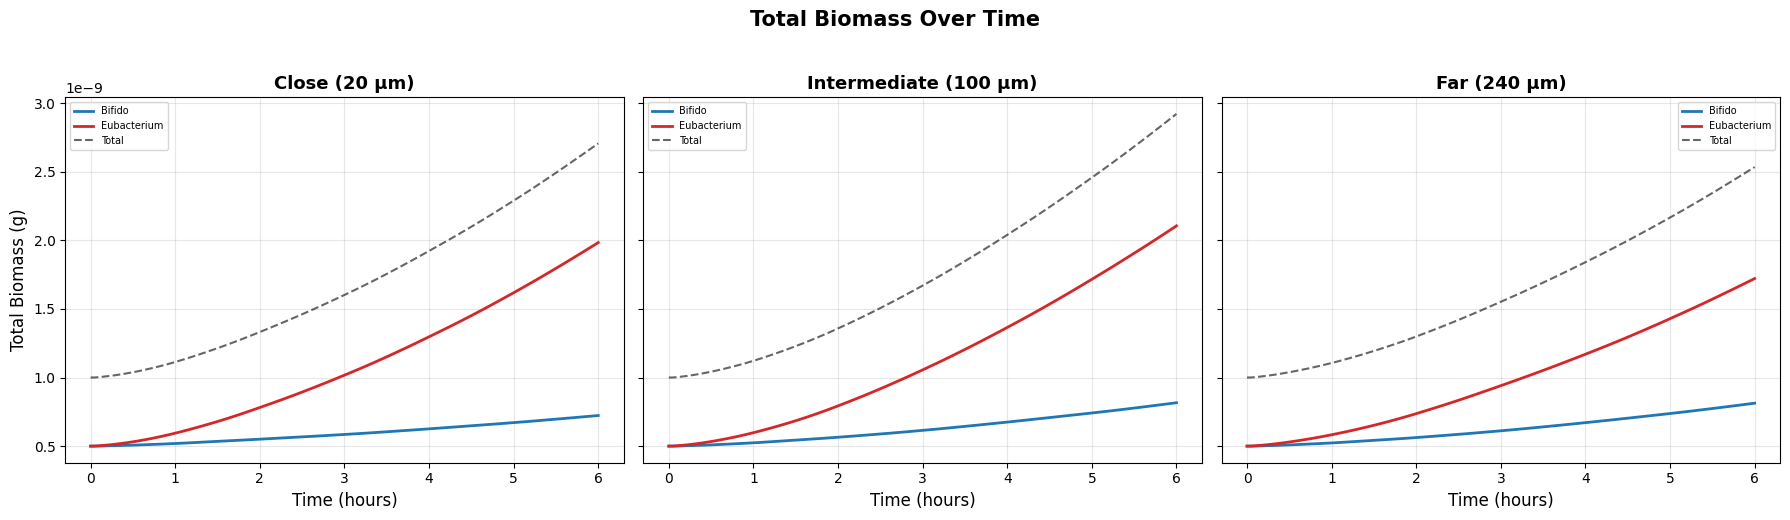

In [13]:
# Total Biomass

scenario_names = list(scenarios.keys())
colors_bif = '#1f77b4'   # blue
colors_eub = '#d62728'   # red

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, name in enumerate(scenario_names):
    ax = axes[i]
    sim = results[name]
    tb = sim.total_biomass
    time_h = tb['cycle'] * TIME_STEP

    ax.plot(time_h, tb['Bifido'], color=colors_bif, linewidth=2, label='Bifido')
    ax.plot(time_h, tb['Eubacterium'], color=colors_eub, linewidth=2, label='Eubacterium')
    ax.plot(time_h, tb['Bifido'] + tb['Eubacterium'], 'k--', linewidth=1.5, alpha=0.6, label='Total')

    ax.set_xlabel('Time (hours)', fontsize=12)
    if i == 0:
        ax.set_ylabel('Total Biomass (g)', fontsize=12)
    ax.set_title(name, fontsize=13, fontweight='bold')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(-9,-9))

plt.suptitle('Total Biomass Over Time', fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
#plt.savefig('biomass_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# # Total Biomass

# scenario_names = list(scenarios.keys())
# line_styles = ['-', '--', ':']
# scenario_colors = ['#2ca02c', '#ff7f0e', '#d62728']

# fig, ax = plt.subplots(figsize=(10, 6))

# for i, name in enumerate(scenario_names):
#     sim = results[name]
#     tb = sim.total_biomass
#     time_h = tb['cycle'] * TIME_STEP

#     ax.plot(time_h, tb['Bifido'], color='#1f77b4', linewidth=2,
#             linestyle=line_styles[i], label=f'Bifido – {name}')
#     ax.plot(time_h, tb['Eubacterium'], color='#d62728', linewidth=2,
#             linestyle=line_styles[i], label=f'Eubacterium – {name}')

# ax.set_xlabel('Time (hours)', fontsize=12)
# ax.set_ylabel('Total Biomass (g)', fontsize=12)
# ax.set_title('Total Biomass Over Time', fontsize=14, fontweight='bold')
# ax.ticklabel_format(axis='y', style='scientific', scilimits=(-9, -9))
# ax.legend(fontsize=9, ncol=2)
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig('biomass_comparison.png', dpi=150, bbox_inches='tight')
# plt.show()

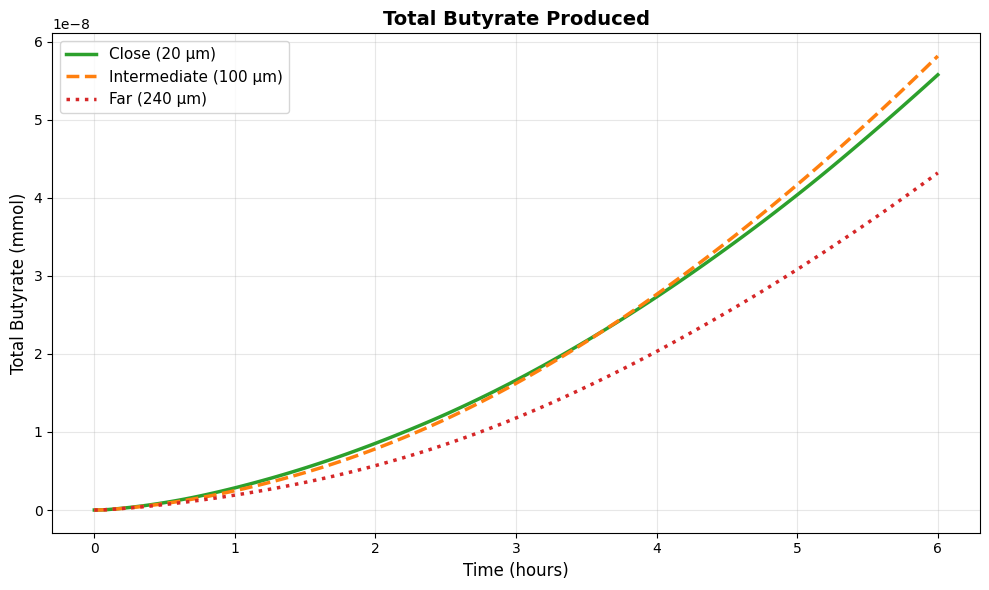

In [15]:
# Total Butyrate

fig, ax = plt.subplots(figsize=(10, 6))

line_styles = ['-', '--', ':']
scenario_colors = ['#2ca02c', '#ff7f0e', '#d62728']

for i, name in enumerate(scenario_names):
    sim = results[name]
    tb = sim.total_biomass
    logged_cycles = tb['cycle'].values
    time_h = logged_cycles * TIME_STEP

    total_butyrate = []
    for cyc in logged_cycles:
        im = sim.get_metabolite_image('but[e]', int(cyc))
        total_butyrate.append(im.sum())

    total_butyrate = np.array(total_butyrate)
    ax.plot(time_h, total_butyrate, color=scenario_colors[i], linewidth=2.5,
            linestyle=line_styles[i], label=name)

ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Total Butyrate (mmol)', fontsize=12)
ax.set_title('Total Butyrate Produced', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig('butyrate_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

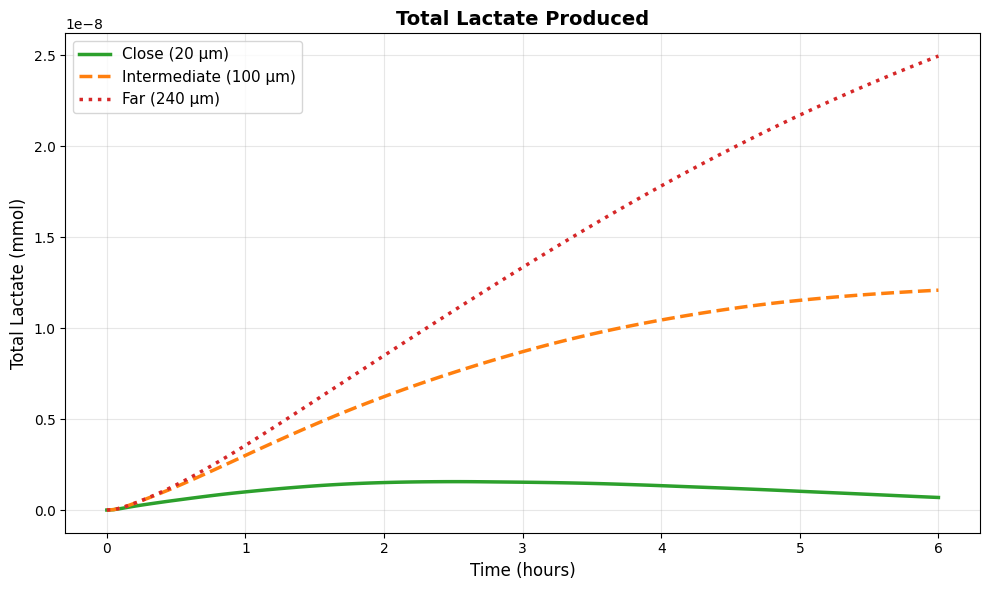

In [16]:
# Total lactate

fig, ax = plt.subplots(figsize=(10, 6))

line_styles = ['-', '--', ':']
scenario_colors = ['#2ca02c', '#ff7f0e', '#d62728']

for i, name in enumerate(scenario_names):
    sim = results[name]
    tb = sim.total_biomass
    logged_cycles = tb['cycle'].values
    time_h = logged_cycles * TIME_STEP

    total_butyrate = []
    for cyc in logged_cycles:
        im = sim.get_metabolite_image('lac_L[e]', int(cyc))
        total_butyrate.append(im.sum())

    total_butyrate = np.array(total_butyrate)
    ax.plot(time_h, total_butyrate, color=scenario_colors[i], linewidth=2.5,
            linestyle=line_styles[i], label=name)

ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Total Lactate (mmol)', fontsize=12)
ax.set_title('Total Lactate Produced', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig('butyrate_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

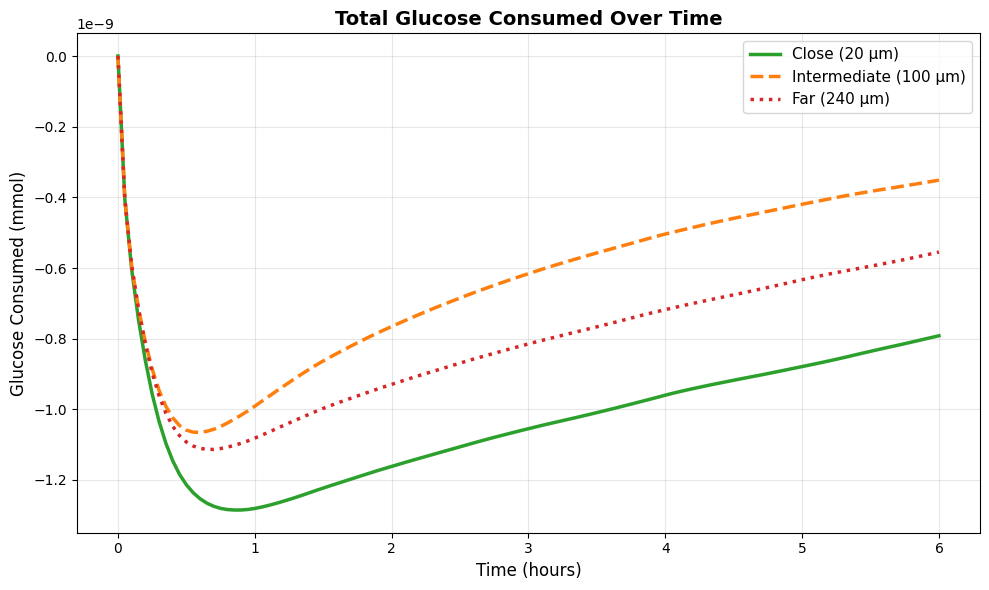

In [17]:
# Total Glucose Consumed

fig, ax = plt.subplots(figsize=(10, 6))

line_styles = ['-', '--', ':']
scenario_colors = ['#2ca02c', '#ff7f0e', '#d62728']

for i, name in enumerate(scenario_names):
    sim = results[name]
    tb = sim.total_biomass
    logged_cycles = tb['cycle'].values
    time_h = logged_cycles * TIME_STEP

    total_glucose = []
    for cyc in logged_cycles:
        im = sim.get_metabolite_image('glc_D[e]', int(cyc))
        total_glucose.append(im.sum())

    total_glucose = np.array(total_glucose)
    glucose_consumed = total_glucose[0] - total_glucose

    ax.plot(time_h, glucose_consumed, color=scenario_colors[i], linewidth=2.5,
            linestyle=line_styles[i], label=name)

ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Glucose Consumed (mmol)', fontsize=12)
ax.set_title('Total Glucose Consumed Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('glucose_consumed.png', dpi=150, bbox_inches='tight')
plt.show()

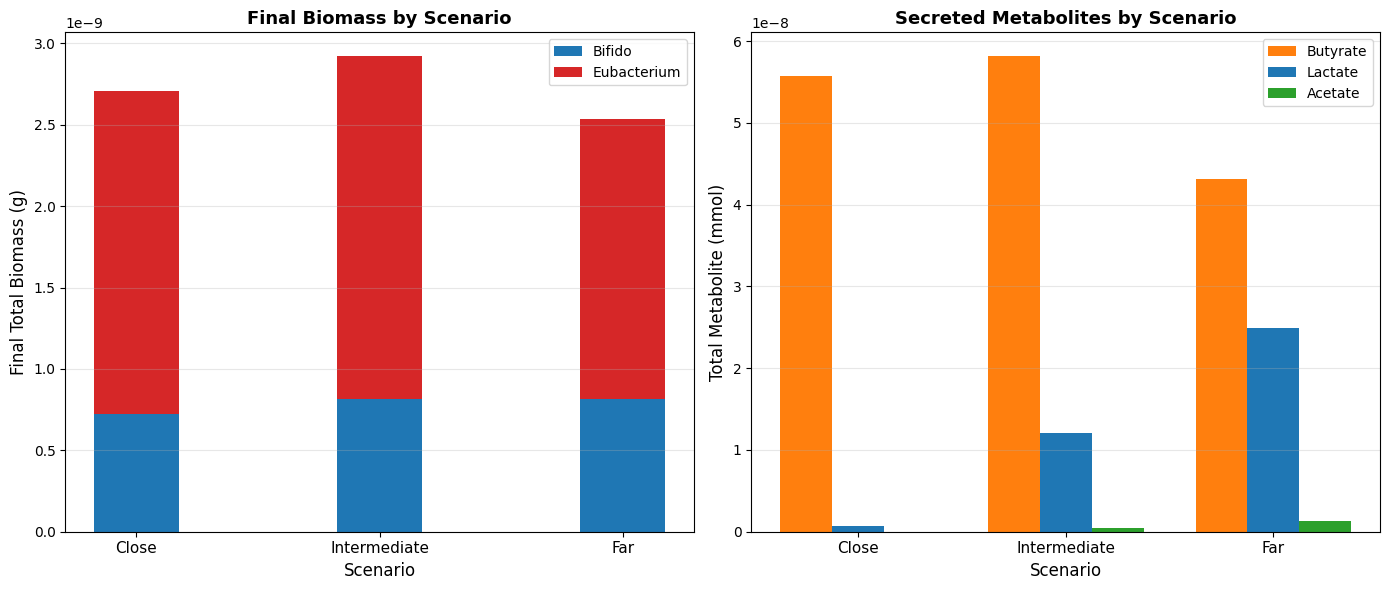

                 Scenario |   Bifido (g) |   Eubact (g) |    Total (g) |     Butyrate
            Close (20 µm) |    7.230e-10 |    1.984e-09 |    2.707e-09 |    5.575e-08
    Intermediate (100 µm) |    8.163e-10 |    2.106e-09 |    2.922e-09 |    5.815e-08
             Far (240 µm) |    8.130e-10 |    1.722e-09 |    2.535e-09 |    4.318e-08


In [18]:
# Bar Chart 

final_bif = []
final_eub = []
final_butyrate = []
final_lactate = []
final_acetate = []

max_cycle = MAX_CYCLES

for name in scenario_names:
    sim = results[name]
    tb = sim.total_biomass
    final_bif.append(tb['Bifido'].iloc[-1])
    final_eub.append(tb['Eubacterium'].iloc[-1])

    # Total metabolite amounts at final cycle   
    but_im = sim.get_metabolite_image('but[e]', max_cycle)
    final_butyrate.append(but_im.sum())
 
    lac_im = sim.get_metabolite_image('lac_L[e]', max_cycle)
    final_lactate.append(lac_im.sum())

    ac_im = sim.get_metabolite_image('ac[e]', max_cycle)
    final_acetate.append(ac_im.sum())


x = np.arange(len(scenario_names))
bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#  biomass bar chart
bars1 = ax1.bar(x, final_bif, bar_width, label='Bifido', color=colors_bif)
bars2 = ax1.bar(x, final_eub, bar_width, bottom=final_bif, label='Eubacterium', color=colors_eub)
ax1.set_xlabel('Scenario', fontsize=12)
ax1.set_ylabel('Final Total Biomass (g)', fontsize=12)
ax1.set_title('Final Biomass by Scenario', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([n.split('(')[0].strip() for n in scenario_names], fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(-9,-9))

#  metabolite bar chart
bar_w = 0.25
bars_but = ax2.bar(x - bar_w, final_butyrate, bar_w, label='Butyrate', color='#ff7f0e')
bars_lac = ax2.bar(x,         final_lactate,  bar_w, label='Lactate',  color='#1f77b4')
bars_ac  = ax2.bar(x + bar_w, final_acetate,  bar_w, label='Acetate',  color='#2ca02c')
ax2.set_xlabel('Scenario', fontsize=12)
ax2.set_ylabel('Total Metabolite (mmol)', fontsize=12)
ax2.set_title('Secreted Metabolites by Scenario', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([n.split('(')[0].strip() for n in scenario_names], fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('summary_bars.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"{'Scenario':>25s} | {'Bifido (g)':>12s} | {'Eubact (g)':>12s} | {'Total (g)':>12s} | {'Butyrate':>12s}")

for i, name in enumerate(scenario_names):
    total = final_bif[i] + final_eub[i]
    print(f"{name:>25s} | {final_bif[i]:>12.3e} | {final_eub[i]:>12.3e} | {total:>12.3e} | {final_butyrate[i]:>12.3e}")


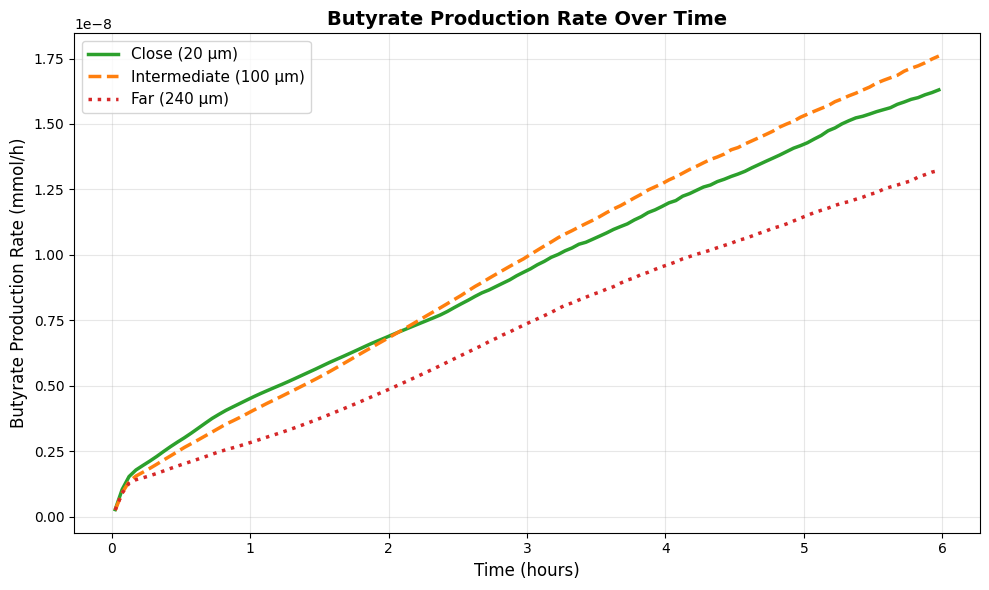

In [19]:
# Butyrate Production Rate

fig, ax = plt.subplots(figsize=(10, 6))

line_styles = ['-', '--', ':']
scenario_colors = ['#2ca02c', '#ff7f0e', '#d62728']

for i, name in enumerate(scenario_names):
    sim = results[name]
    tb = sim.total_biomass
    logged_cycles = tb['cycle'].values
    time_h = logged_cycles * TIME_STEP

    total_butyrate = []
    for cyc in logged_cycles:
        im = sim.get_metabolite_image('but[e]', int(cyc))
        total_butyrate.append(im.sum())

    total_butyrate = np.array(total_butyrate)

    #  rate (d[butyrate]/dt)
    dt = np.diff(time_h)
    d_but = np.diff(total_butyrate)
    rate = d_but / dt
    time_mid = (time_h[:-1] + time_h[1:]) / 2

    ax.plot(time_mid, rate, color=scenario_colors[i], linewidth=2.5,
            linestyle=line_styles[i], label=name)

ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Butyrate Production Rate (mmol/h)', fontsize=12)
ax.set_title('Butyrate Production Rate Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('butyrate_rate.png', dpi=150, bbox_inches='tight')
plt.show()

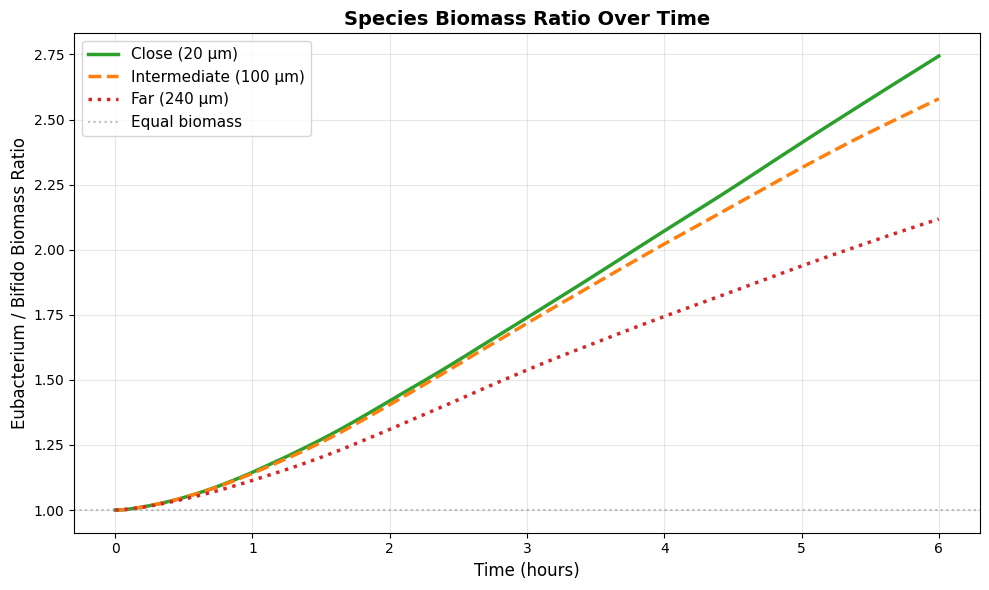

In [20]:
# Eubacterium to Bifido Biomass Ratio

fig, ax = plt.subplots(figsize=(10, 6))

for i, name in enumerate(scenario_names):
    sim = results[name]
    tb = sim.total_biomass
    time_h = tb['cycle'] * TIME_STEP
    ratio = tb['Eubacterium'] / tb['Bifido'].clip(lower=1e-30)
    ax.plot(time_h, ratio, color=scenario_colors[i], linewidth=2.5,
            linestyle=line_styles[i], label=name)

ax.set_xlabel('Time (hours)', fontsize=12)
ax.set_ylabel('Eubacterium / Bifido Biomass Ratio', fontsize=12)
ax.set_title('Species Biomass Ratio Over Time', fontsize=14, fontweight='bold')
ax.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Equal biomass')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig('biomass_ratio.png', dpi=150, bbox_inches='tight')
plt.show()

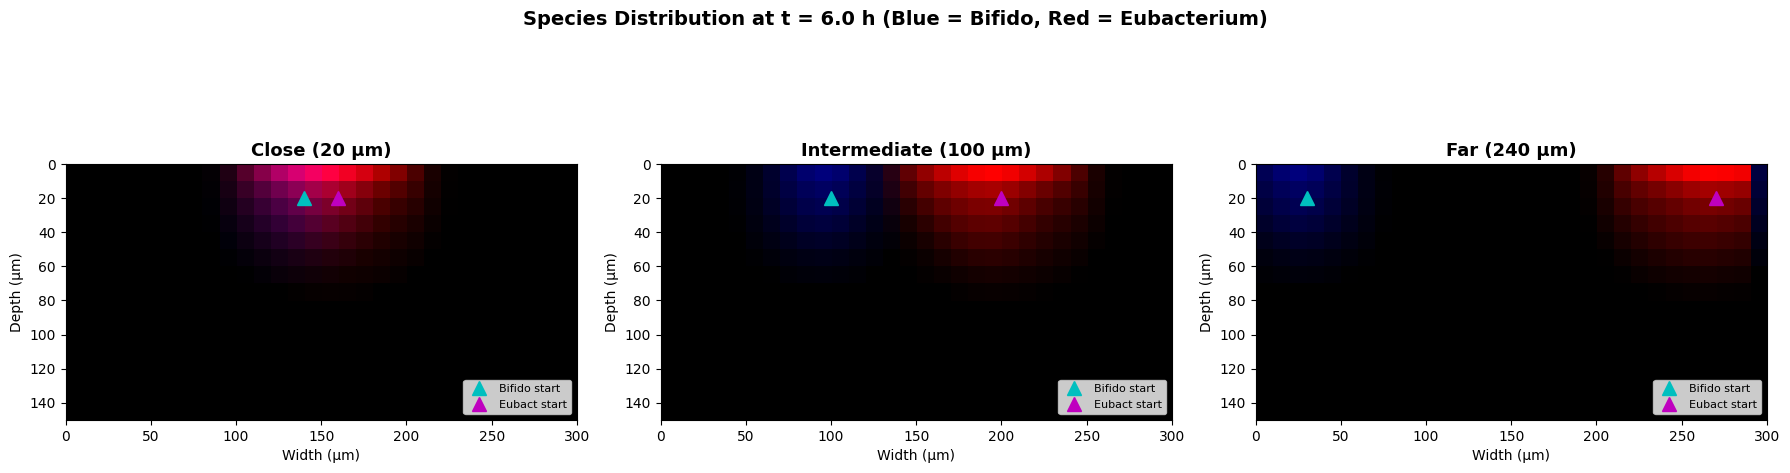

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(scenario_names):
    ax = axes[i]
    sim = results[name]

    im_b = sim.get_biomass_image('Bifido', MAX_CYCLES)
    im_e = sim.get_biomass_image('Eubacterium', MAX_CYCLES)
    im_b = np.roll(im_b, shift=1, axis=1)
    im_e = np.roll(im_e, shift=1, axis=1)

    scale = max(im_b.max(), im_e.max(), 1e-20)

    rgb = np.zeros((GRID_Y, GRID_X, 3))
    rgb[:, :, 2] = (im_b / scale).T   # Bifido = blue
    rgb[:, :, 0] = (im_e / scale).T   # Eubacterium = red
    rgb = np.clip(rgb, 0, 1)

    ax.imshow(rgb, origin='upper', aspect='equal',
              extent=[0, GRID_X*SPACE_WIDTH*1e4, GRID_Y*SPACE_WIDTH*1e4, 0])
    ax.set_title(name, fontsize=13, fontweight='bold')
    ax.set_xlabel('Width (µm)')
    ax.set_ylabel('Depth (µm)')

    # Mark initial positions
    pos = scenarios[name]
    ax.plot(pos['x_bif']*SPACE_WIDTH*1e4, y_init*SPACE_WIDTH*1e4, 'c^', markersize=10, label='Bifido start')
    ax.plot(pos['x_eub']*SPACE_WIDTH*1e4, y_init*SPACE_WIDTH*1e4, 'm^', markersize=10, label='Eubact start')
    ax.legend(fontsize=8, loc='lower right')

plt.suptitle(f'Species Distribution at t = {MAX_CYCLES*TIME_STEP:.1f} h (Blue = Bifido, Red = Eubacterium)',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
#plt.savefig('species_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

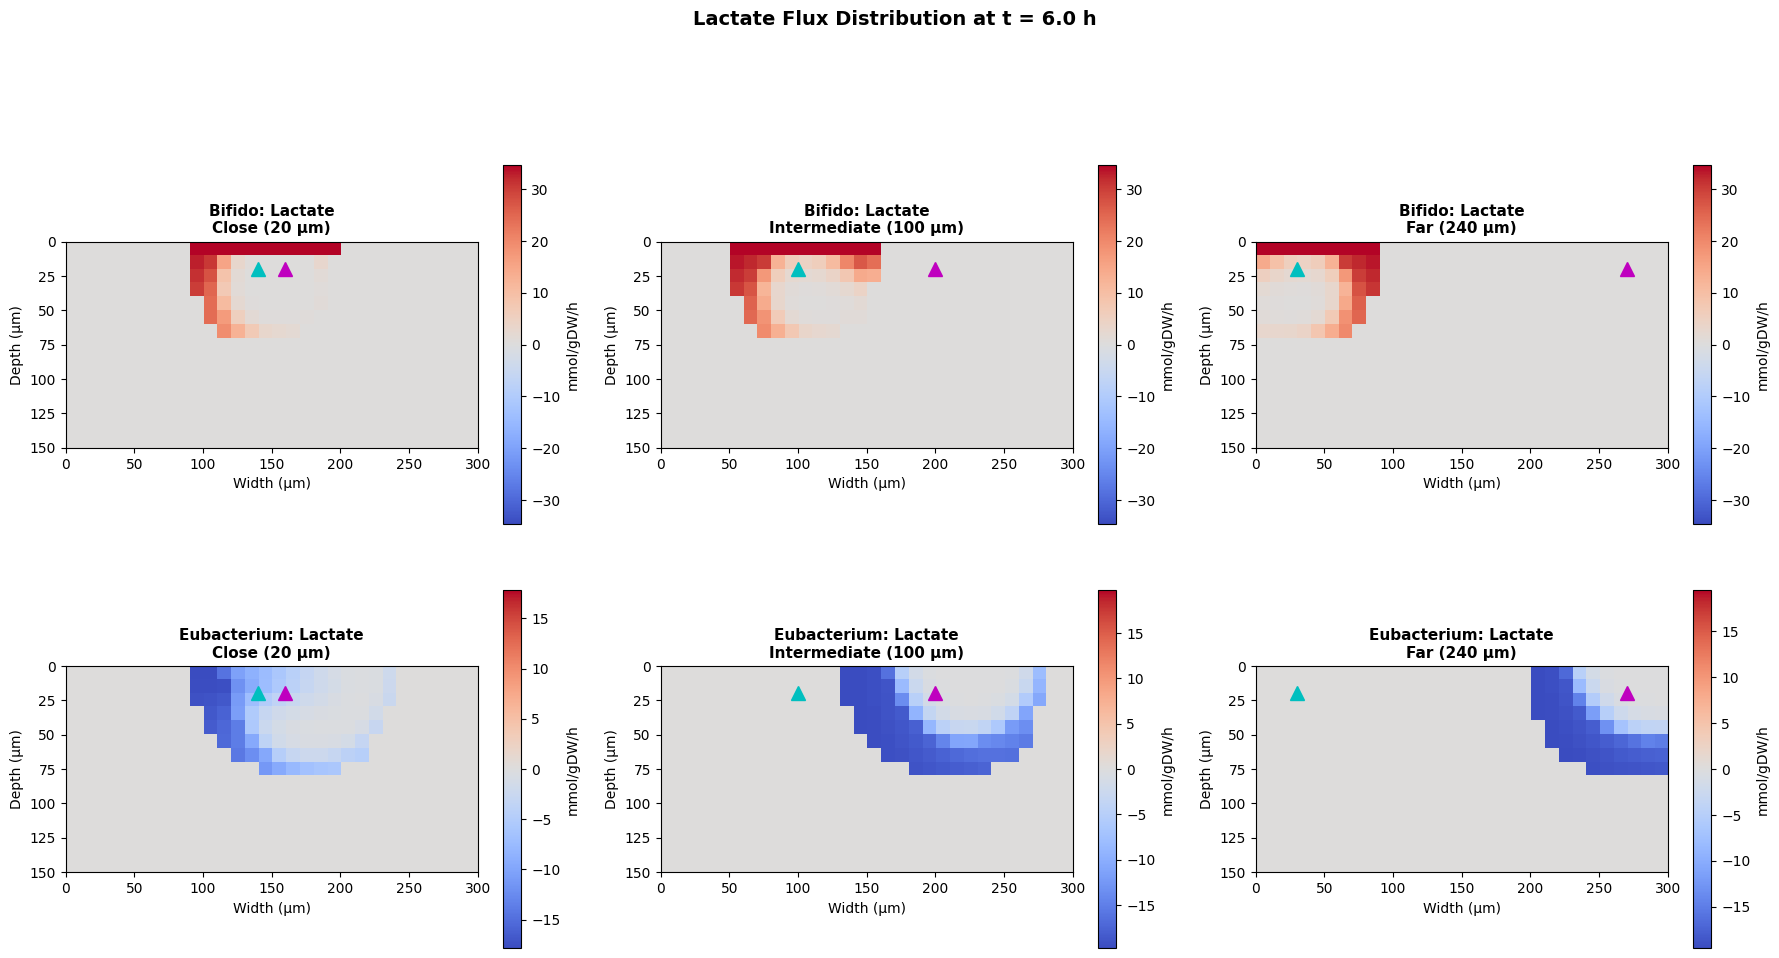

In [22]:
# Lactate Flux Distribution

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

cyc = MAX_CYCLES

for i, name in enumerate(scenario_names):
    sim = results[name]
    pos = scenarios[name]

    # Bifido lactate production
    im_bif = sim.get_flux_image('Bifido', 'EX_lac_L(e)', cyc).astype(float)
    ax = axes[0, i]
    vmax = max(abs(im_bif).max(), 1e-20)
    pcm = ax.imshow(im_bif.T, origin='upper', cmap='coolwarm', aspect='equal',
                    vmin=-vmax, vmax=vmax,
                    extent=[0, GRID_X*SPACE_WIDTH*1e4, GRID_Y*SPACE_WIDTH*1e4, 0])
    ax.plot(pos['x_bif']*SPACE_WIDTH*1e4, y_init*SPACE_WIDTH*1e4, 'c^', markersize=10)
    ax.plot(pos['x_eub']*SPACE_WIDTH*1e4, y_init*SPACE_WIDTH*1e4, 'm^', markersize=10)
    ax.set_title(f'Bifido: Lactate\n{name}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Width (µm)')
    ax.set_ylabel('Depth (µm)')
    plt.colorbar(pcm, ax=ax, shrink=0.7, label='mmol/gDW/h')

    # Eubacterium lactate consumption
    im_eub = sim.get_flux_image('Eubacterium', 'EX_lac_L(e)', cyc).astype(float)
    ax = axes[1, i]
    vmax = max(abs(im_eub).max(), 1e-20)
    pcm = ax.imshow(im_eub.T, origin='upper', cmap='coolwarm', aspect='equal',
                    vmin=-vmax, vmax=vmax,
                    extent=[0, GRID_X*SPACE_WIDTH*1e4, GRID_Y*SPACE_WIDTH*1e4, 0])
    ax.plot(pos['x_bif']*SPACE_WIDTH*1e4, y_init*SPACE_WIDTH*1e4, 'c^', markersize=10)
    ax.plot(pos['x_eub']*SPACE_WIDTH*1e4, y_init*SPACE_WIDTH*1e4, 'm^', markersize=10)
    ax.set_title(f'Eubacterium: Lactate\n{name}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Width (µm)')
    ax.set_ylabel('Depth (µm)')
    plt.colorbar(pcm, ax=ax, shrink=0.7, label='mmol/gDW/h')

plt.suptitle(f'Lactate Flux Distribution at t = {cyc*TIME_STEP:.1f} h',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('lactate_flux_distribution.png', dpi=150, bbox_inches='tight')
plt.show()